In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.gridspec import GridSpec
import os
import glob
from nilearn import plotting, surface, datasets
from nilearn import image as nli


# Figure options
fm = matplotlib.font_manager.json_load(os.path.expanduser("~/.cache/matplotlib/fontlist-v310.json"))
fm.findfont("Arial", rebuild_if_missing=True)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 7
plt.rcParams['pdf.fonttype'] = 42
opt_subtitle = { 'fontname':"Arial", 'fontweight':"bold", 'fontsize':11 }

fig_size_double = 19/2.54
fig_size_half   = 14/2.54
fig_size_single =  9/2.54
fig_size_min    =  3/2.54
dpi = 300

plt.style.use('default')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
col_learners = colors[6]
col_nonlearners = colors[9]
col_player1 = colors[0]
col_player2 = colors[1]
col_gray = '#666666'




behavior_df = pd.read_csv('behavior.csv')
behavior_df.set_index('subject', inplace=True)

rating_df = pd.read_csv('ratings.csv')
rating_df.set_index('subject', inplace=True)

voi_csv = 'params_modpsc_VOI'
brain_df = pd.read_csv(f'{voi_csv}_betas.csv')
voi_df = brain_df[ (brain_df['voi']=='Amy-BLA') ]
voi_df.set_index('subject', inplace=True)

/usr/local/lib/python3.8/dist-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


*       Amy-BLA     introduction:    +0.08±0.03, U30=686.0, p=0.0020, d=0.8
*       Amy-CEN     introduction:    +0.06±0.02, U30=611.0, p=0.0336, d=0.5
*        Septal     introduction:    +0.06±0.02, U30=640.0, p=0.0126, d=0.6
figure-3


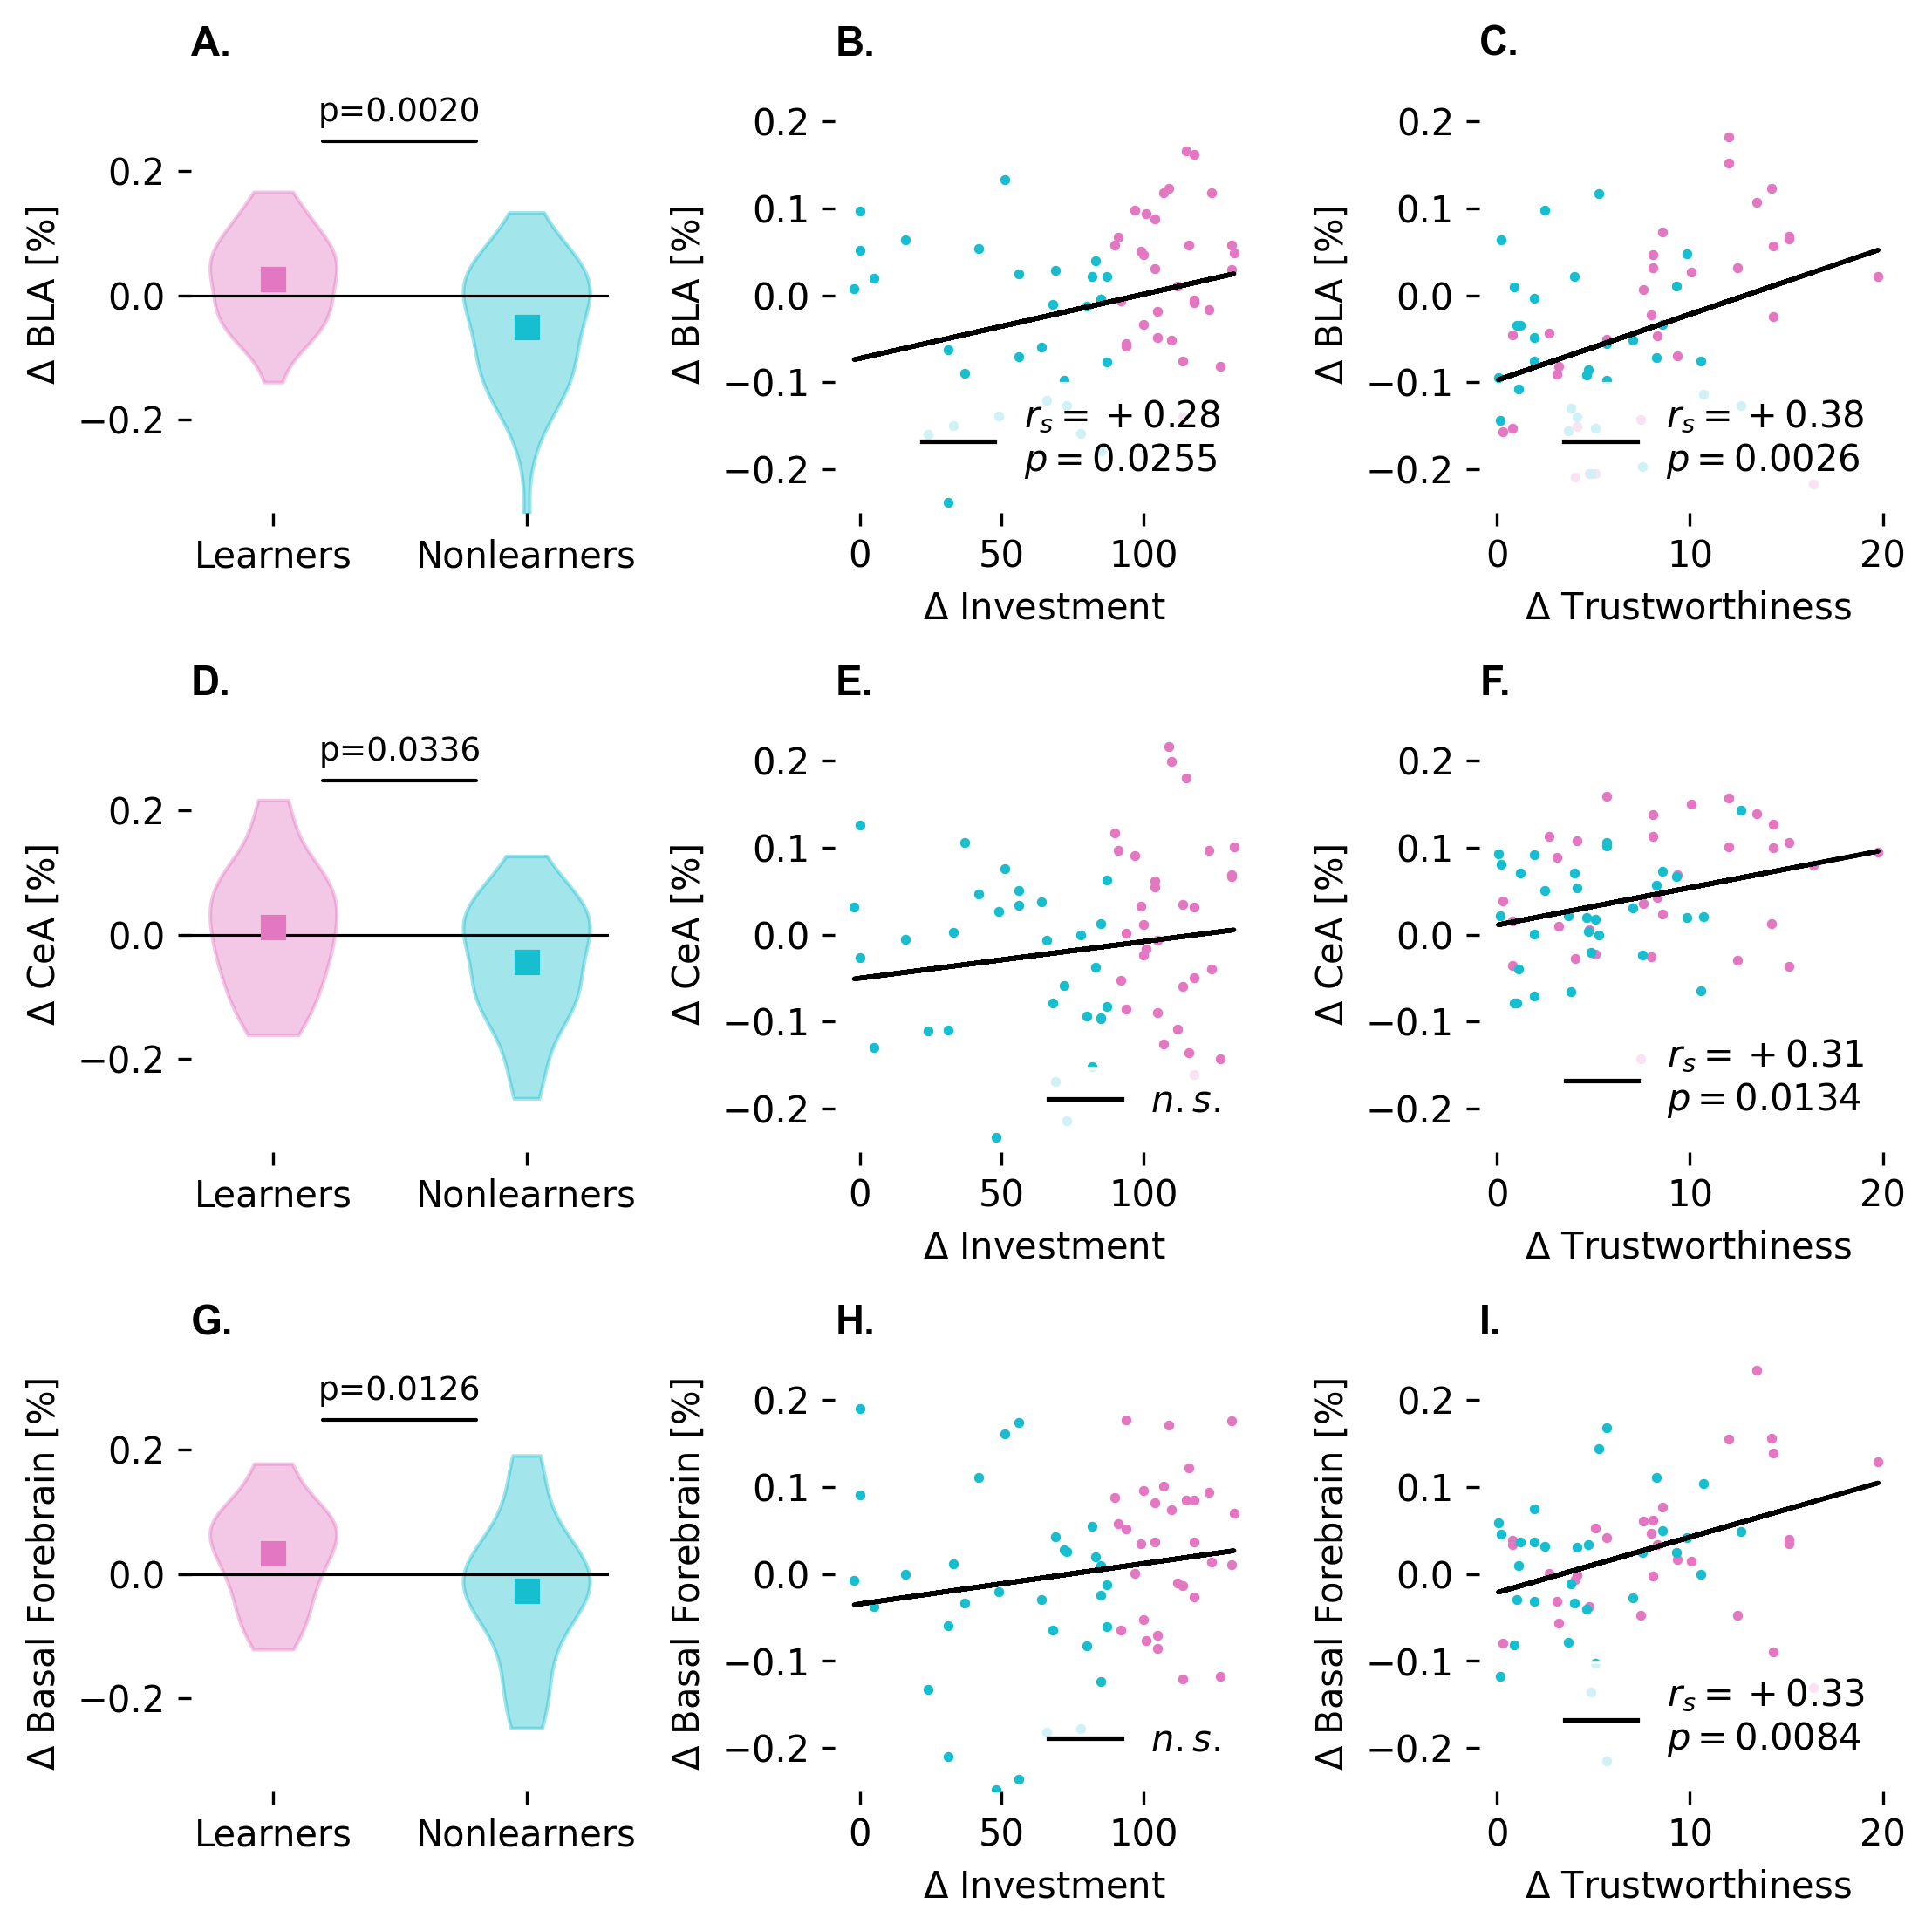

In [19]:
median_gain = np.median( behavior_df['gain'] )
median_diff_invest = np.median( behavior_df['diff_invest'] )
selector = behavior_df['diff_invest'] > median_diff_invest # good learners

vois = ['Amy-BLA','Amy-CEN', 'Septal']    
voinames = ['BLA','CeA', 'Basal Forebrain']   

conditions = ['introduction']   



# def adjacent_values(vals, q1, q3):
#     upper_adjacent_value = q3 + (q3 - q1) * 1.5
#     upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

#     lower_adjacent_value = q1 - (q3 - q1) * 1.5
#     lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
#     return lower_adjacent_value, upper_adjacent_value

rows=3
cols=3

fig, axes = plt.subplots(rows, cols, figsize=(fig_size_double, rows*fig_size_double/3), dpi=dpi, sharey='none', squeeze=False)

for v, voi in enumerate( vois ):
    condition = conditions[0]
    

    brain_df = pd.read_csv(f'{voi_csv}_betas.csv')
    voi_df = brain_df[ (brain_df['voi']==voi) ]
    voi_df.set_index('subject', inplace=True)
    
    sel = selector
    ax = axes[v,0]
    y1 = np.mean( voi_df.loc[sel & (voi_df['condition']==f'{condition}_2'), 'b1':'b20'], axis=1) - np.mean( voi_df.loc[sel & (voi_df['condition']==f'{condition}_1'), 'b1':'b20'] , axis=1)
    y2 = np.mean( voi_df.loc[~sel & (voi_df['condition']==f'{condition}_2'), 'b1':'b20'], axis=1) - np.mean( voi_df.loc[~sel & (voi_df['condition']==f'{condition}_1'), 'b1':'b20'] , axis=1)
        
    data = [y1, y2]

    ax.axhline(0, color='k', linewidth=0.75)

    parts = ax.violinplot(data, showmeans=False, showmedians=False, showextrema=False)
    for pc in parts['bodies']:
        pc.set_alpha(0.4)
    parts['bodies'][0].set_facecolor(col_learners)
    parts['bodies'][0].set_edgecolor(col_learners)
    ax.plot(1,np.mean(data[0]), 's', color=col_learners)
    parts['bodies'][1].set_facecolor(col_nonlearners)
    parts['bodies'][1].set_edgecolor(col_nonlearners)
    ax.plot(2,np.mean(data[1]), 's', color=col_nonlearners)
     

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    ax.set_ylim([-0.35, 0.35])
    
    ax.set_ylabel(f'$\Delta$ {voinames[v]} [%]')
    ax.set_xticks([1,2])
    ax.set_xticklabels(('Learners', 'Nonlearners'))

    statres = scipy.stats.mannwhitneyu( y1, y2, alternative='greater' )
    stattext =  f'p={statres.pvalue:0.4f}' #T={statres.statistic:+0.2}, 
    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':25,'shrinkB':25,'linewidth':1}
    
    ax.annotate(stattext, xy=(1.5,0.28), zorder=10, ha='center', fontsize=9)
    ax.annotate('', xy=(1,0.125), xytext=(2,0.125), arrowprops=props)
    
    thresh = 0.05
    d = np.abs( ( np.mean(y1)-np.mean(y2) )/np.std( np.concatenate((y1, y2)) ) )
    ci = np.abs( 1.96 *  ( np.mean(y1)-np.mean(y2) ) / np.sqrt(len(y1)) )
    caption = "%s %12s %16s:    %+0.2f±%0.2f, U%d=%0.1f, p=%.4f, d=%0.1f" % (('* ' if statres.pvalue<thresh else '  '), voi, condition, np.mean(y1)-np.mean(y2), ci, len(y1)-1, np.abs(statres.statistic), statres.pvalue, d ) 
    print(caption)      
    

for x_meas in ['diff_invest']: 
    for v, voi in enumerate( vois ):
        for condition in conditions:
            voi_df = brain_df[ (brain_df['voi']==voi) ]
            voi_df.set_index('subject', inplace=True)

            p = 2
            ax = axes[v,1]
            con = f'Player {p}'
            y = np.mean( voi_df[ voi_df['condition']==f'{condition}_{2}' ].loc[:,'b1':'b20'], axis=1 ) - np.mean( voi_df[ voi_df['condition']==f'{condition}_{1}' ].loc[:,'b1':'b20'], axis=1 )
            
            x = behavior_df[ behavior_df.index.isin( voi_df[ voi_df['condition']==f'{condition}_1' ].loc[:,'b1':'b20'].index ) ][x_meas]
            rho, pval = stats.spearmanr(x,y) 
            if pval < 0.05:
                corrtxt = f'$r_s={rho:+0.2f}$\n$p={pval:0.4f}$'
            else:
                corrtxt = f'$n.s.$'

            try:
                b, m = polyfit(x, y, 1)
                    
                    
                style_grp = {'marker':'.', 'fillstyle':'full', 'markersize':3.5, 'alpha':1.00, 'linestyle':'none' }
                ax.plot(x[selector], y[selector], label='Learners', color = col_learners, **style_grp )
                ax.plot(x[~selector], y[~selector], label='Nonlearners', color = col_nonlearners, **style_grp )
                    
                g, = ax.plot(x, b + m * x, '-', color='k', linewidth=1.25, label=f'{corrtxt}', antialiased=True)
                leg = ax.legend(handles=[g], loc='lower right')
                leg.get_frame().set_edgecolor('#ffffff')

                ax.set_ylabel(f'$\Delta$ {voinames[v]} [%]')
                ax.set_xlabel('$\Delta$ Investment')
                ax.set(frame_on=False)
                ax.set_ylim([-0.25, 0.25])
            except:
                False
                
                
                

                
                
for x_meas in ['rating4']: 
    for v, voi in enumerate( vois ):
        for condition in conditions:
            voi_df = brain_df[ (brain_df['voi']==voi) ]
            voi_df.set_index('subject', inplace=True)

            p = 2
            ax = axes[v,2]
            con = f'Player {p}'
            y = np.mean( voi_df[ voi_df['condition']==f'{condition}_{p}' ].loc[:,'b1':'b20'], axis=1 )
            x = rating_df[ behavior_df.index.isin( voi_df[ voi_df['condition']==f'{condition}_1' ].loc[:,'b1':'b20'].index ) ][x_meas]

            rho, pval = stats.spearmanr(x,y) 

            corrtxt = f'$r_s={rho:+0.2f}$\n$p={pval:0.4f}$'

            try:
                b, m = polyfit(x, y, 1)
 
                style_grp = {'marker':'.', 'fillstyle':'full', 'markersize':3.5, 'alpha':1.00, 'linestyle':'none' }
                ax.plot(x[selector], y[selector], label='Learners', color = col_learners, **style_grp )
                ax.plot(x[~selector], y[~selector], label='Nonlearners', color = col_nonlearners, **style_grp )    
                    
                    
                g, = ax.plot(x, b + m * x, '-', color='k', linewidth=1.25, label=f'{corrtxt}', antialiased=True)
                leg = ax.legend(handles=[g], loc='lower right')
                leg.get_frame().set_edgecolor('#ffffff')

                ax.set_ylabel(f'$\Delta$ {voinames[v]} [%]')
                ax.set_xlabel('$\Delta$ Trustworthiness')
                ax.set(frame_on=False)
                ax.set_ylim([-0.25, 0.25])
            except:
                False
                
axes[0,0].set_title('A.', loc='left', fontdict=opt_subtitle )
axes[0,1].set_title('B.', loc='left', fontdict=opt_subtitle )
axes[0,2].set_title('C.', loc='left', fontdict=opt_subtitle )
axes[1,0].set_title('D.', loc='left', fontdict=opt_subtitle )
axes[1,1].set_title('E.', loc='left', fontdict=opt_subtitle )
axes[1,2].set_title('F.', loc='left', fontdict=opt_subtitle )
axes[2,0].set_title('G.', loc='left', fontdict=opt_subtitle )
axes[2,1].set_title('H.', loc='left', fontdict=opt_subtitle )
axes[2,2].set_title('I.', loc='left', fontdict=opt_subtitle )
                
plt.tight_layout()

fig_output_file = 'figure-3'
print(fig_output_file)
fig.savefig(f'{fig_output_file}.png', bbox_inches='tight', pad_inches=0.25, facecolor='w', edgecolor='w') 
fig.savefig(f'{fig_output_file}.pdf', bbox_inches='tight', pad_inches=0.25, facecolor='w', edgecolor='w')